# Deep embedded clustering

In [2]:
# machine learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from sklearn.utils import Bunch

#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns



In [3]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

# Import Covariates dataframe

In [4]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df["PST/Sol."].head()

0     3.211407
1    24.448314
2     9.807453
3     7.243925
4     6.893438
Name: PST/Sol., dtype: float64

In [58]:
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "Canton", "mountain_binary"])
#print(categorical_columns)
# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
#print(encoded_categorical)
# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "Canton", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical.astype(int)], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
transformed_df.dtypes
transformed_df.to_csv("../../data/cleaned_data/numeric_covariates.csv")

Transformed DataFrame:


In [40]:
print(transformed_df.dtypes)  # Display the data types of each column
print(transformed_df.isna().any(axis=1))  # Inspect the first few rows
transformed_df = transformed_df.apply(pd.to_numeric, errors='coerce').fillna(0)
transformed_df.head()

Population                                                                float64
Yes [nbr]                                                                 float64
No [nbr]                                                                  float64
0-19 years                                                                float64
20-64 years                                                               float64
65 years or older                                                         float64
Private households                                                        float64
Housing and infrastructure area (%)                                       float64
Total employment                                                          float64
Primary sector                                                            float64
Secondary sector                                                          float64
Tertiary sector                                                           float64
New housing unit

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
0,1998.0,444.0,335.0,392.0,1232.0,357.0,848.0,25.075949,442.0,39.0,...,0,0,0,0,1,0,0,1,0,0
1,12859.0,1884.0,1260.0,2481.0,7587.0,2235.0,5412.0,377.385470,6920.0,47.0,...,0,0,0,0,1,0,0,1,0,0
2,5678.0,1197.0,706.0,1317.0,3334.0,921.0,2327.0,86.126344,1014.0,34.0,...,0,0,0,0,1,0,0,1,0,0
3,3974.0,764.0,555.0,832.0,2244.0,675.0,1552.0,47.609905,1021.0,93.0,...,0,0,0,0,1,0,0,1,0,0
4,3963.0,809.0,580.0,817.0,2329.0,632.0,1580.0,74.868902,1478.0,29.0,...,0,0,0,0,1,0,0,1,0,0


Numpy array dtype: float64
Data type: <class 'sklearn.utils._bunch.Bunch'>
{'data': array([[1.9980e+03, 4.4400e+02, 3.3500e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2859e+04, 1.8840e+03, 1.2600e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.6780e+03, 1.1970e+03, 7.0600e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.6700e+02, 9.7000e+01, 1.1400e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]]), 'target': RangeIndex(start=0, stop=2131, step=1)}
Tensor shape: torch.Size([2131, 50])
Epoch 0/100, Loss: 5866874860470272.0
Epoch 10/100, Loss: 5866874860470272.0
Epoch 20/100, Loss: 5866874860470272.0
Epoch 30/100, Loss: 5866874860470272.0
Epoch 40/100, Loss: 5866874860470272.0
Epoch 50/100, Loss: 5866874860470272.0
Epoch 60/100, Loss

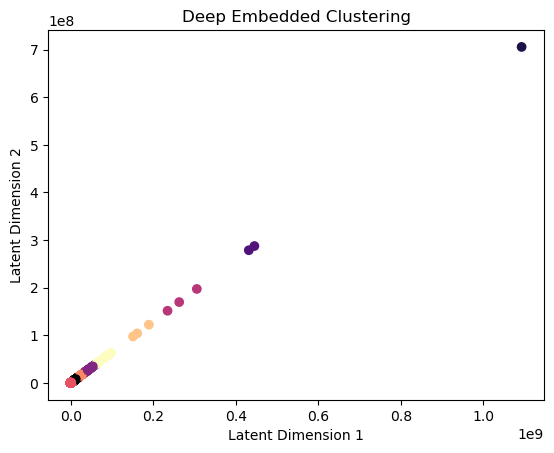

In [41]:
# Step 1: Replace NaNs and ensure numeric conversion
df = transformed_df.copy()  # Work on a copy
df = df.replace(np.nan, 0)  # Replace NaNs with 0
df = df.apply(pd.to_numeric, errors='coerce').fillna(0)  # Force numeric conversion

df.to_csv("../../data/cov_to_cluster.csv")
# Step 2: Convert to numpy array
X = df.to_numpy()
print(f"Numpy array dtype: {X.dtype}")  # Ensure dtype is numeric

# Step 3: Create Bunch object
data = Bunch(data=X, target=transformed_df.index)
print(f"Data type: {type(data)}")
print(data)

# Step 4: Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
print(f"Tensor shape: {X_tensor.shape}")

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]  # Number of features (e.g., 4 for Iris dataset)
encoding_dim = 2  # Number of dimensions in the embedded space (latent space)
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    decoded, encoded = model(X_tensor)
    loss = criterion(decoded, X_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Extract the learned embeddings (latent space)
with torch.no_grad():
    model.eval()
    _, encoded_features = model(X_tensor)

# Apply KMeans clustering to the embeddings
encoded_features = encoded_features.numpy()  # Convert to numpy for KMeans
kmeans = KMeans(n_clusters=9)
kmeans.fit(encoded_features)
labels = kmeans.labels_

# Plot the clustered data in the 2D embedded space
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=labels, cmap='magma')
plt.title('Deep Embedded Clustering')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [49]:
Covariates_trans_df = transformed_df.copy()
Covariates_trans_df["label"] = labels
Covariates_trans_df.head()

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh,label
0,1998.0,444.0,335.0,392.0,1232.0,357.0,848.0,25.075949,442.0,39.0,...,0,0,0,1,0,0,1,0,0,0
1,12859.0,1884.0,1260.0,2481.0,7587.0,2235.0,5412.0,377.385470,6920.0,47.0,...,0,0,0,1,0,0,1,0,0,6
2,5678.0,1197.0,706.0,1317.0,3334.0,921.0,2327.0,86.126344,1014.0,34.0,...,0,0,0,1,0,0,1,0,0,0
3,3974.0,764.0,555.0,832.0,2244.0,675.0,1552.0,47.609905,1021.0,93.0,...,0,0,0,1,0,0,1,0,0,0
4,3963.0,809.0,580.0,817.0,2329.0,632.0,1580.0,74.868902,1478.0,29.0,...,0,0,0,1,0,0,1,0,0,0


In [50]:
group = Covariates_trans_df.groupby("label").mean()
group

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
label,,,,,,,,,,,,,,,,,,,,,
0,4613.219457,634.484163,542.907240,921.056561,2686.020362,837.852941,1914.640271,101.271656,1986.242081,87.606335,...,0.113122,0.316742,0.000000,0.058824,0.493213,0.126697,0.217195,0.733032,0.049774,0.000000
1,433989.000000,86847.000000,25386.000000,73514.000000,284691.000000,62012.000000,204411.000000,26041.886202,491193.000000,177.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,191482.000000,29756.000000,9616.500000,32883.500000,123082.000000,32626.000000,88992.000000,16889.502483,186026.000000,32.500000,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000
3,17904.629630,2627.555556,1596.444444,3461.370370,10633.388889,3228.129630,7602.888889,782.714260,11176.092593,83.777778,...,0.092593,0.166667,0.000000,0.000000,0.611111,0.203704,0.277778,0.722222,0.000000,0.000000
4,133487.666667,27808.000000,7798.666667,24039.666667,84343.000000,20674.666667,61979.666667,5364.199973,128554.666667,206.666667,...,0.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.333333,0.666667,0.000000,0.000000
5,929.380376,127.896505,139.445565,187.694220,542.192876,169.184812,380.578629,10.231834,337.774866,46.748656,...,0.036962,0.353495,0.006048,0.173387,0.347446,0.116263,0.319892,0.603495,0.065860,0.010081
6,10344.173554,1485.429752,1075.173554,2003.123967,5983.950413,1917.636364,4330.950413,325.477342,5551.090909,92.809917,...,0.206612,0.247934,0.000000,0.024793,0.561983,0.157025,0.181818,0.809917,0.008264,0.000000
7,65247.333333,12213.666667,5048.333333,10964.000000,40341.666667,11682.666667,30930.000000,2617.223340,68948.666667,166.666667,...,0.000000,0.666667,0.000000,0.000000,0.333333,0.000000,0.000000,1.000000,0.000000,0.000000
8,27999.882353,4765.058824,2458.411765,5382.411765,16563.058824,5295.117647,12348.647059,1155.479636,17029.882353,107.058824,...,0.000000,0.176471,0.000000,0.058824,0.647059,0.117647,0.235294,0.764706,0.000000,0.000000


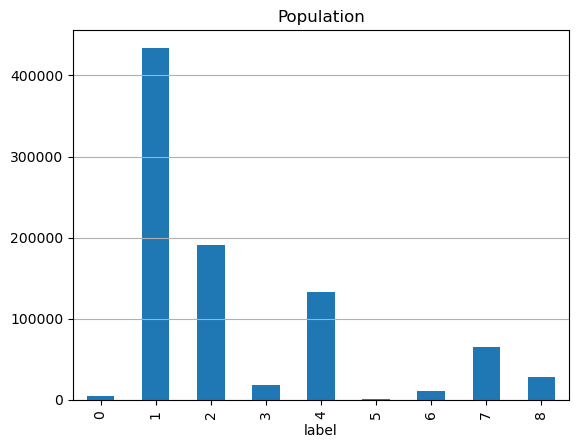

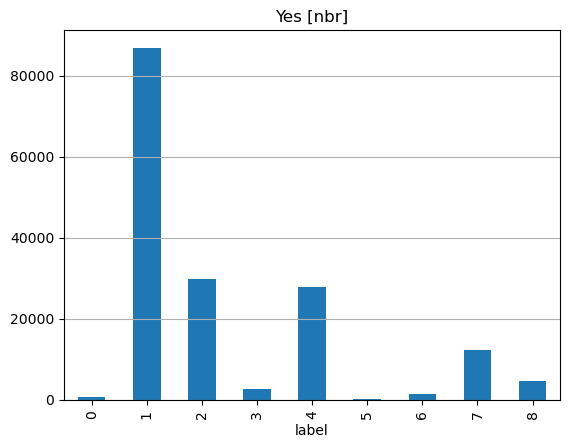

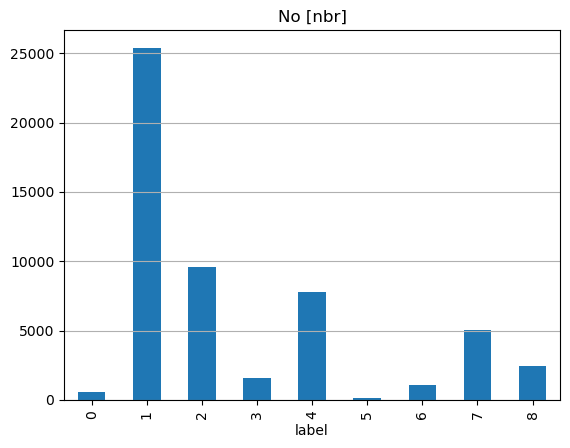

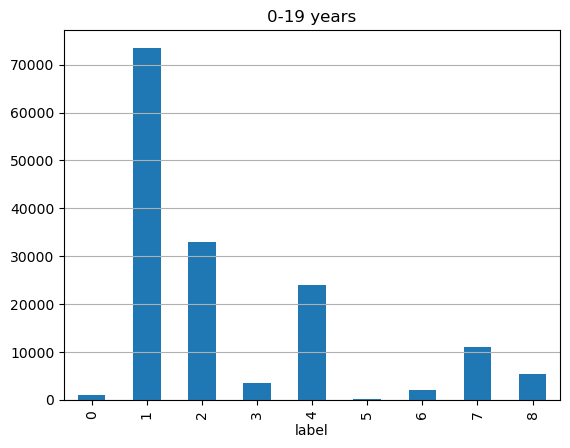

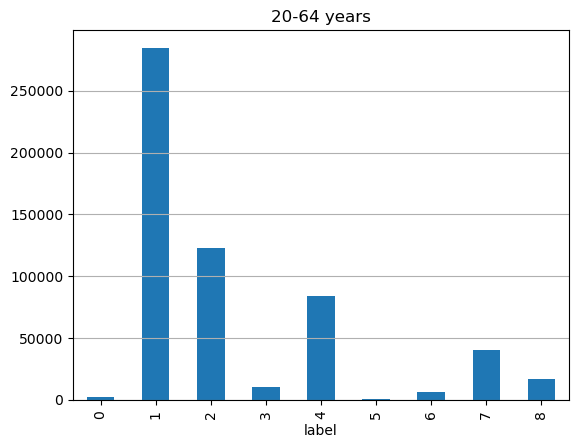

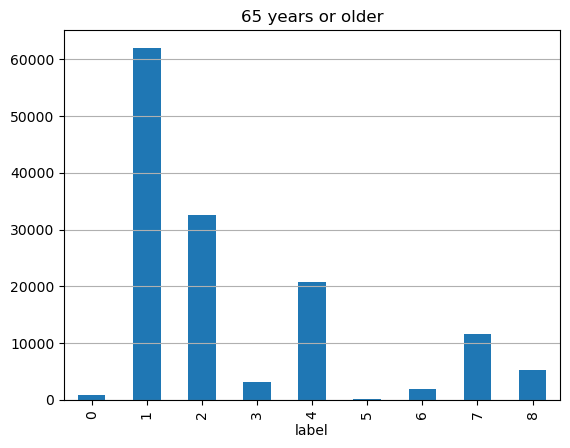

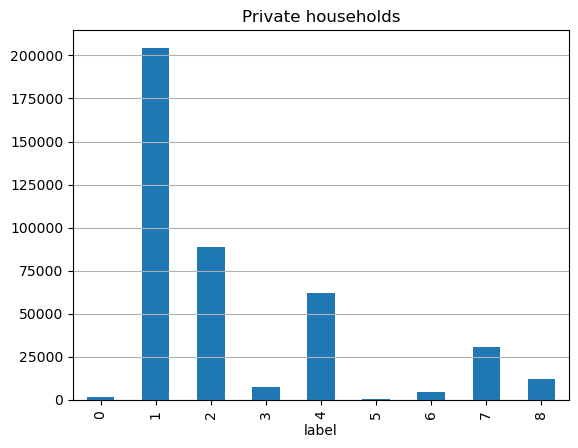

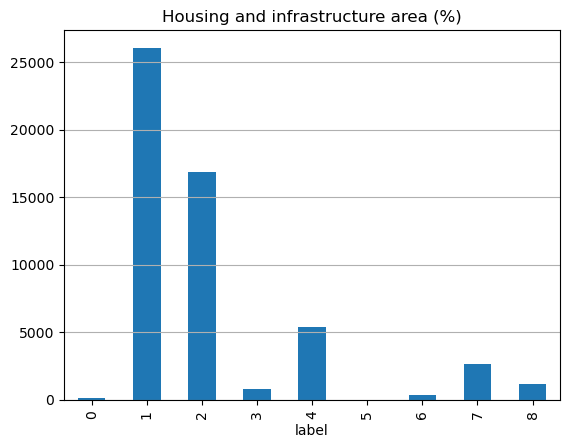

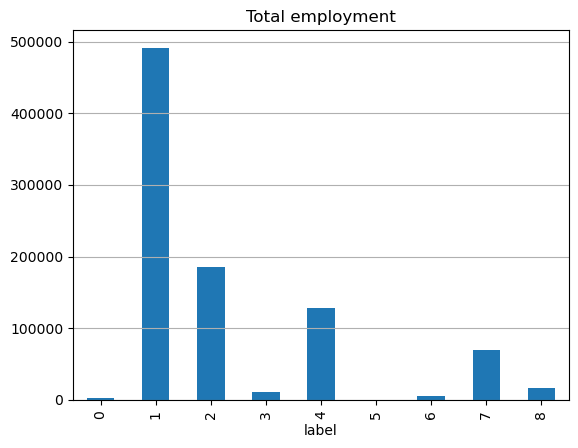

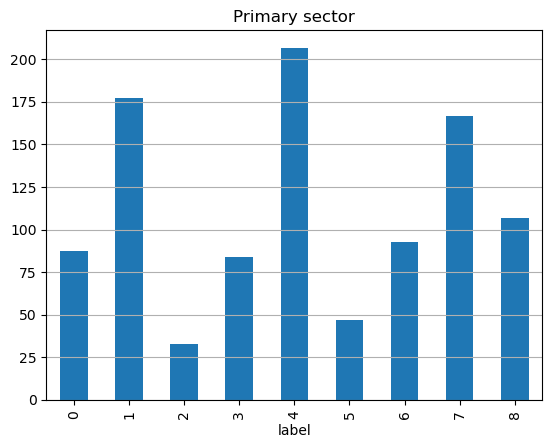

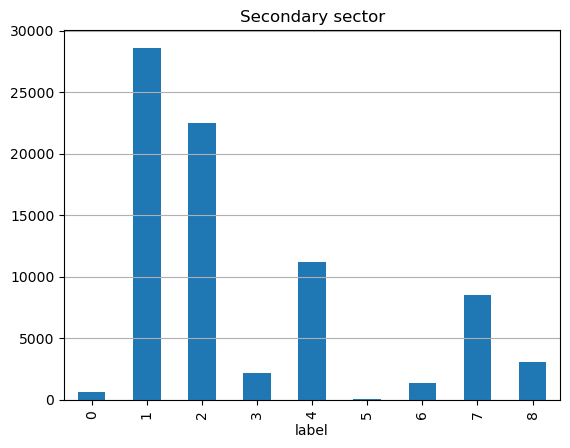

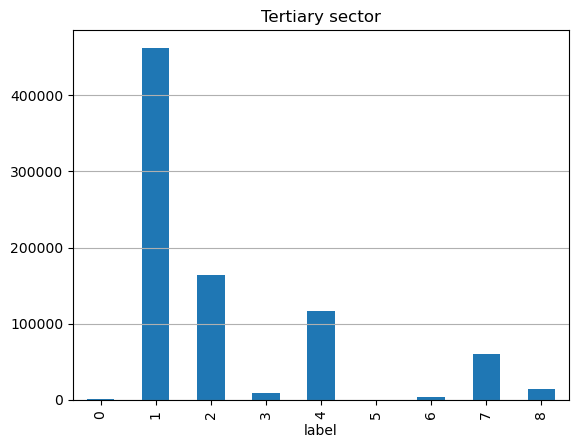

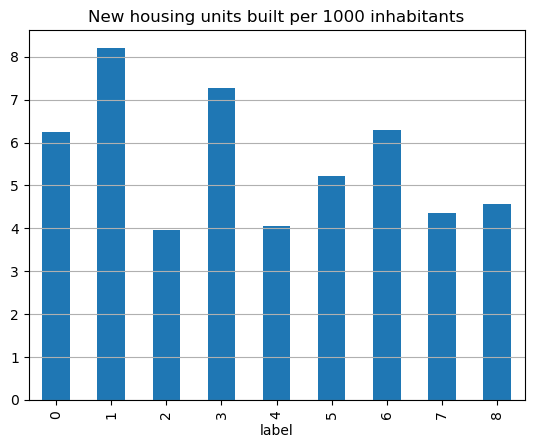

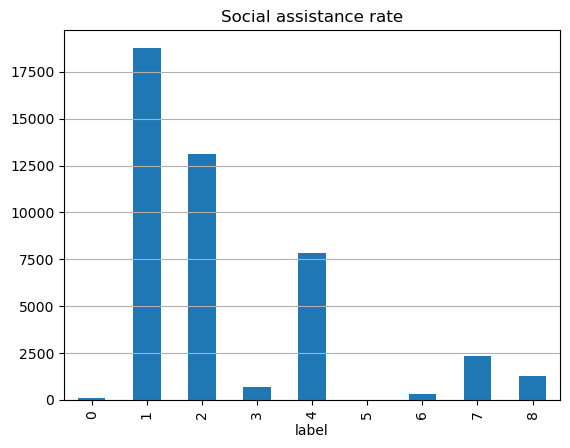

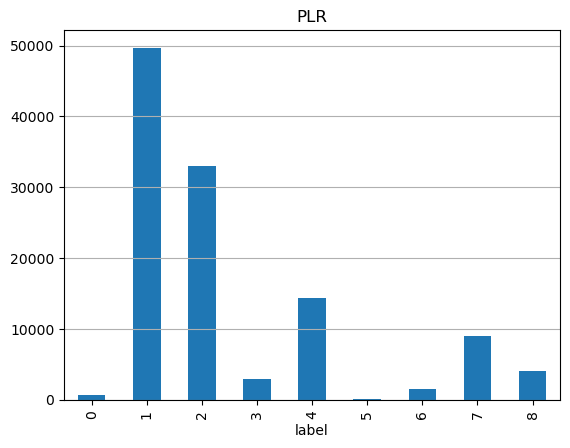

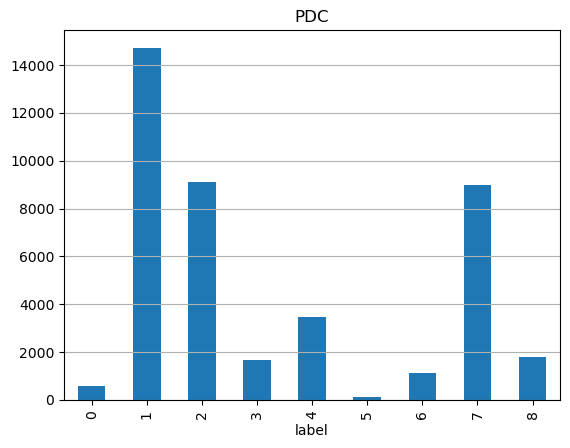

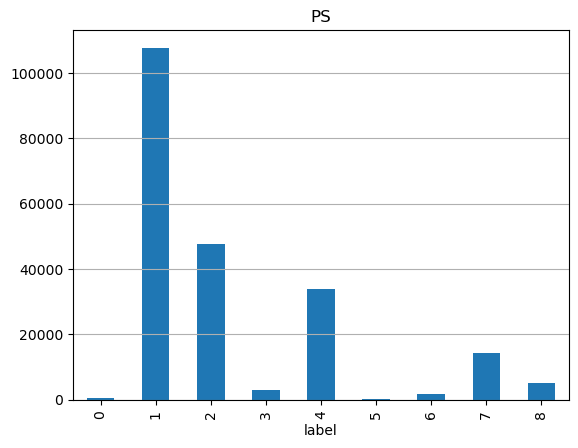

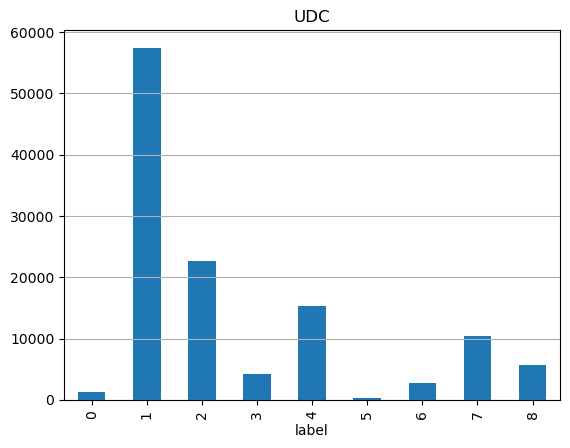

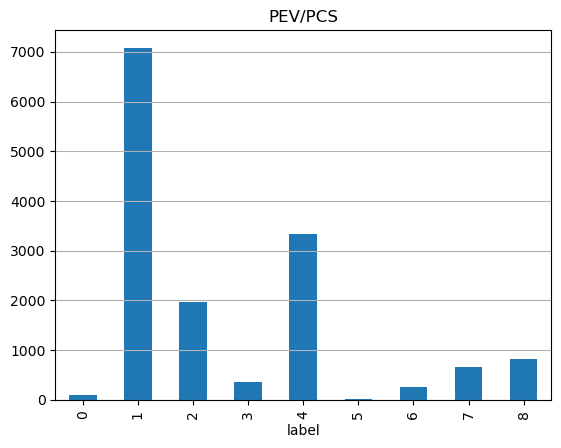

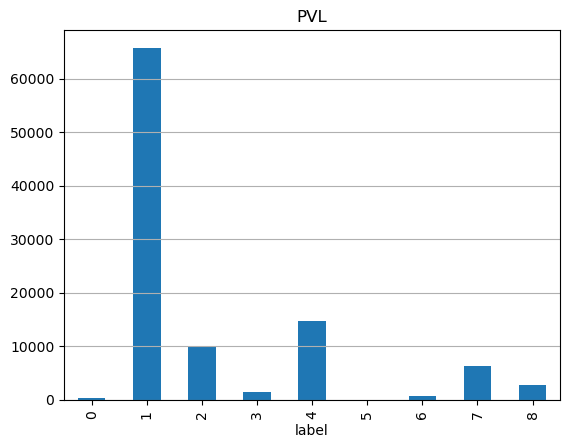

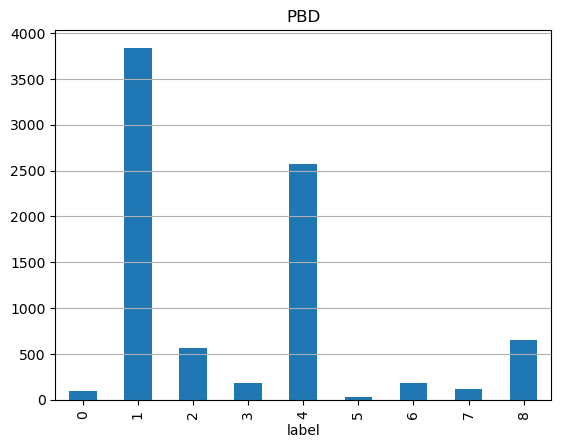

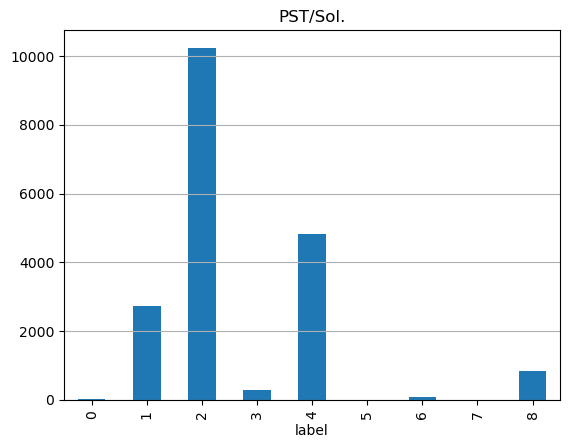

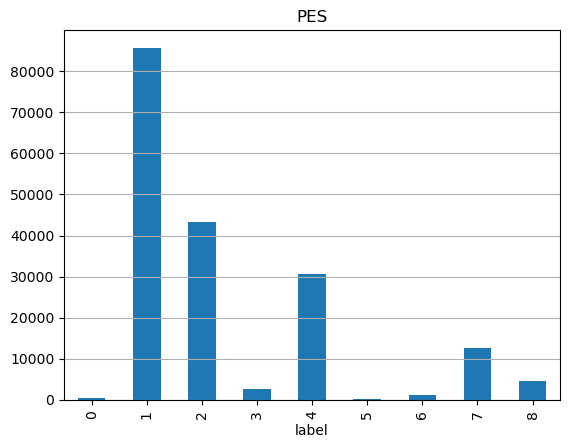

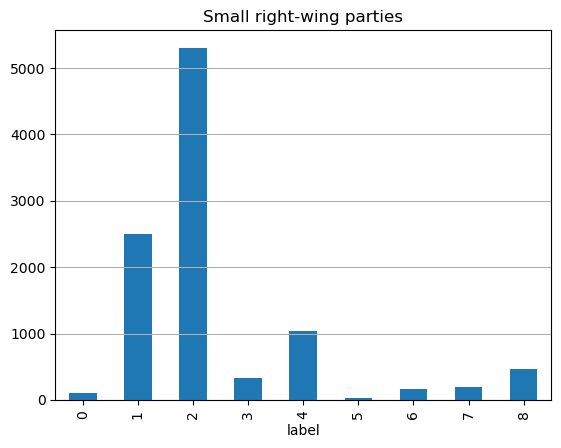

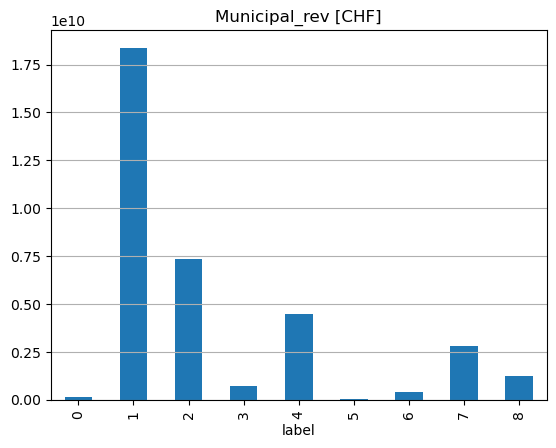

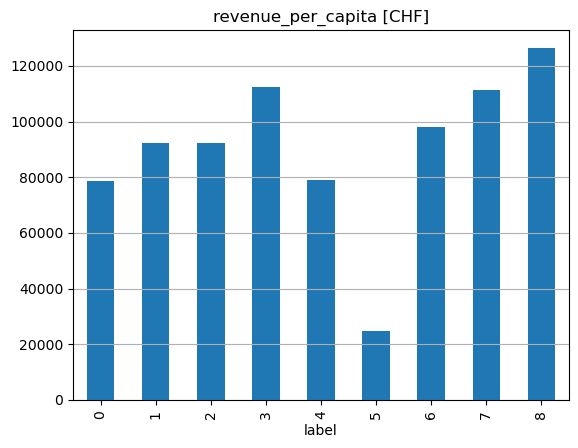

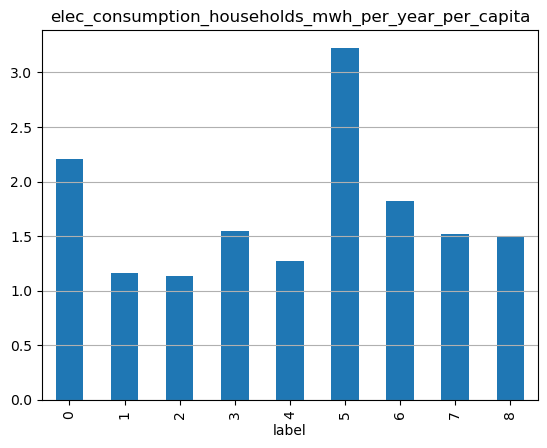

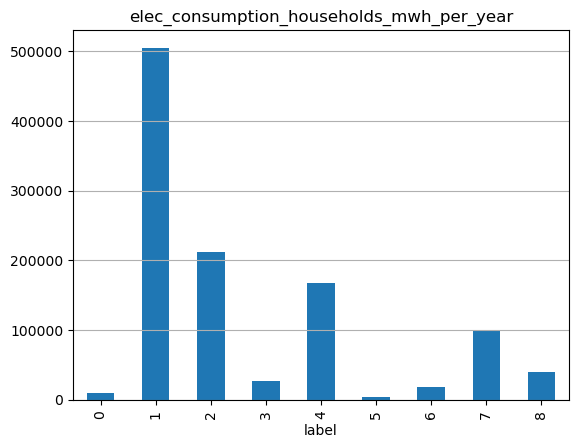

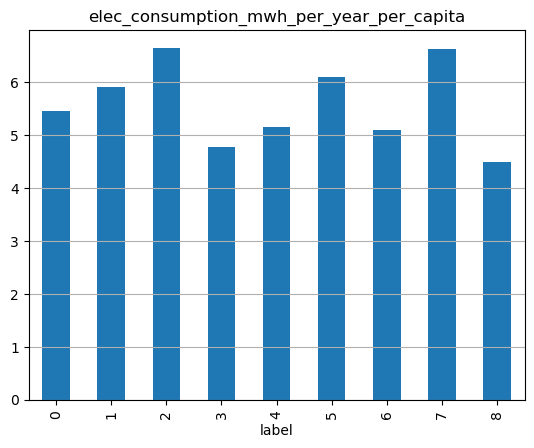

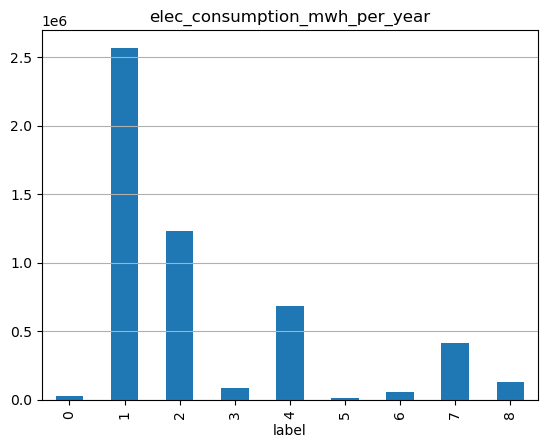

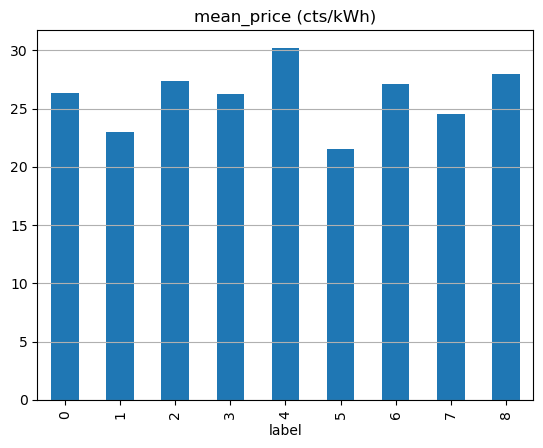

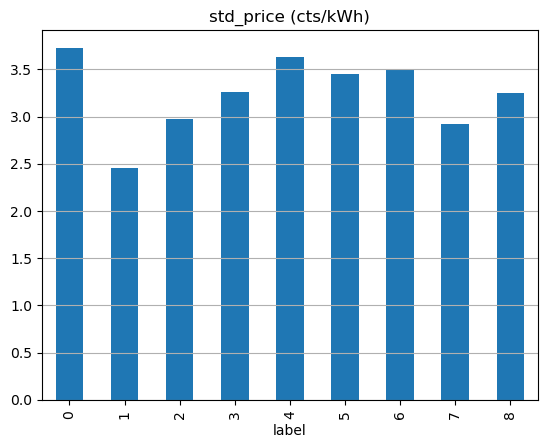

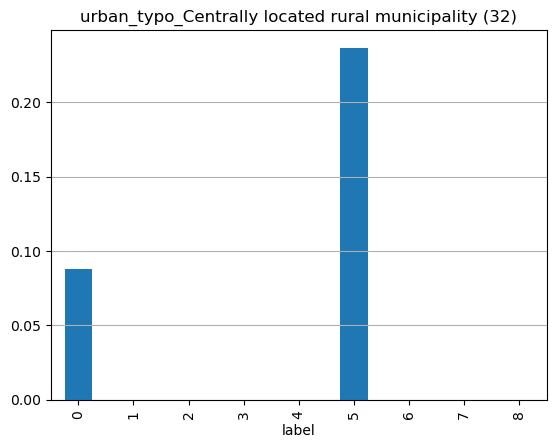

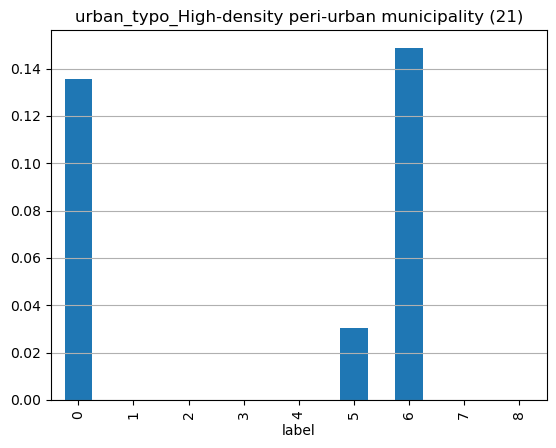

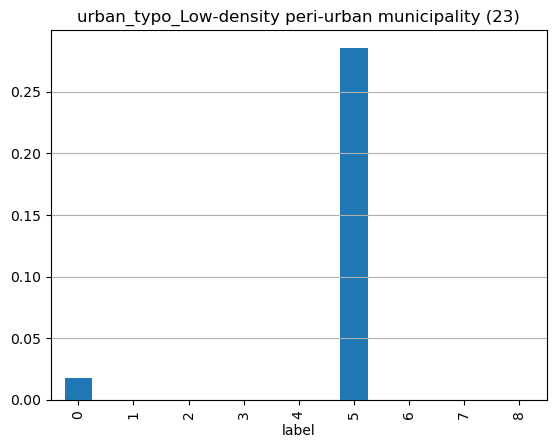

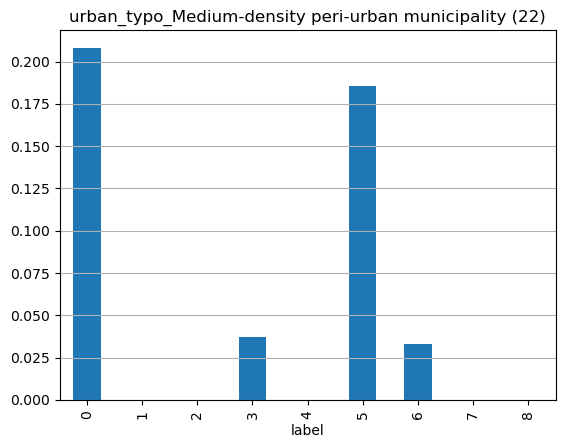

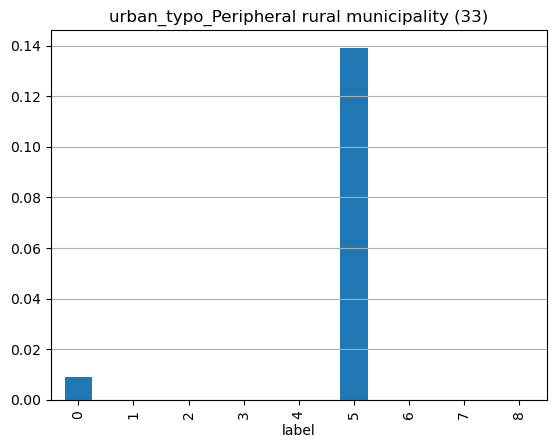

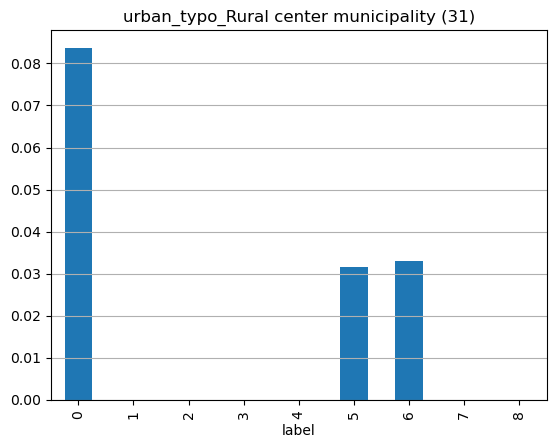

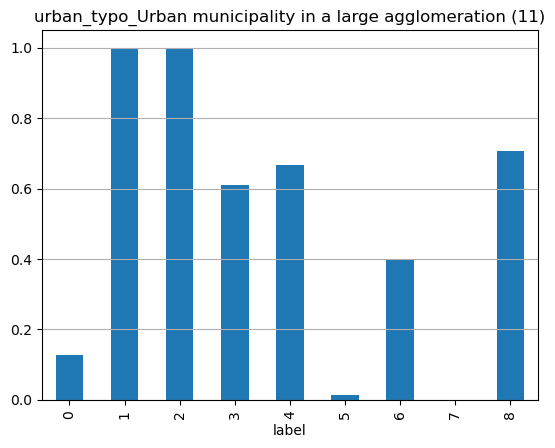

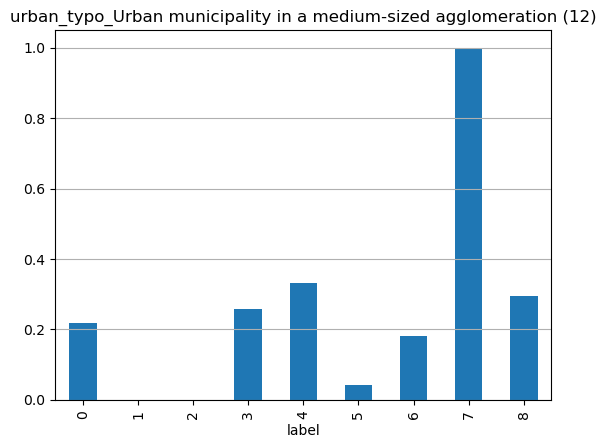

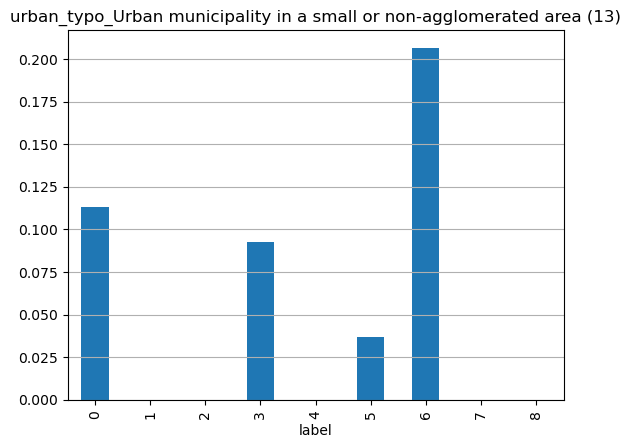

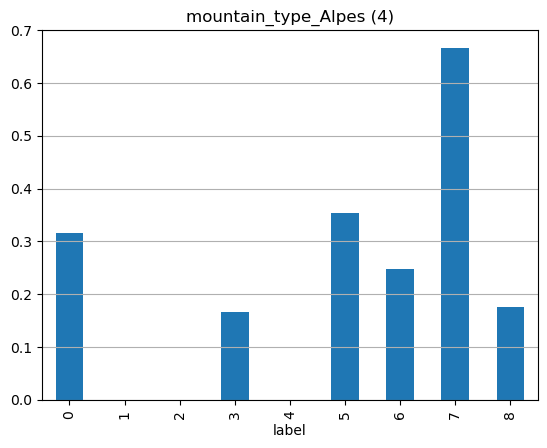

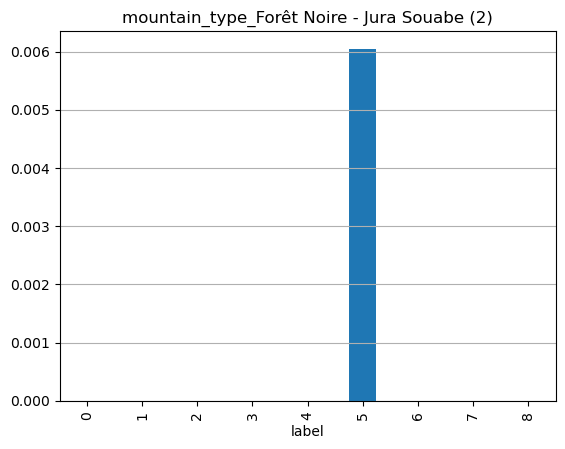

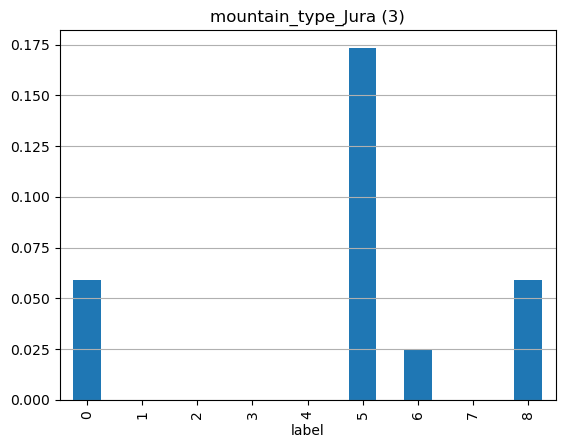

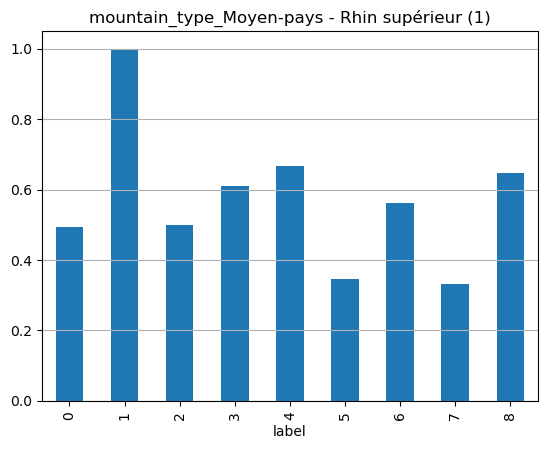

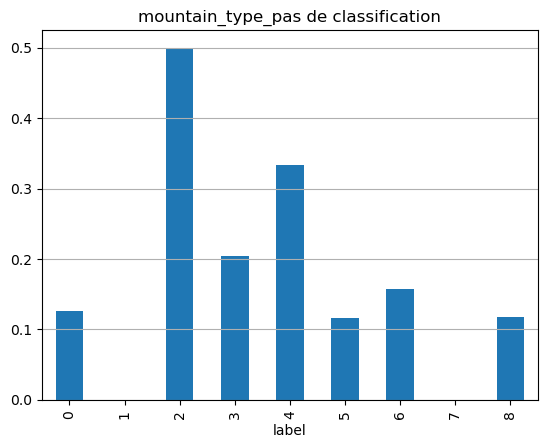

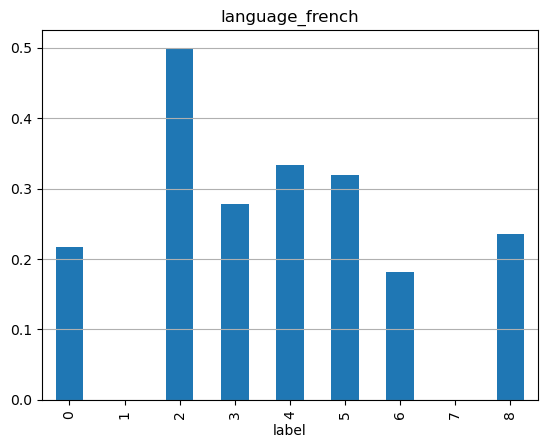

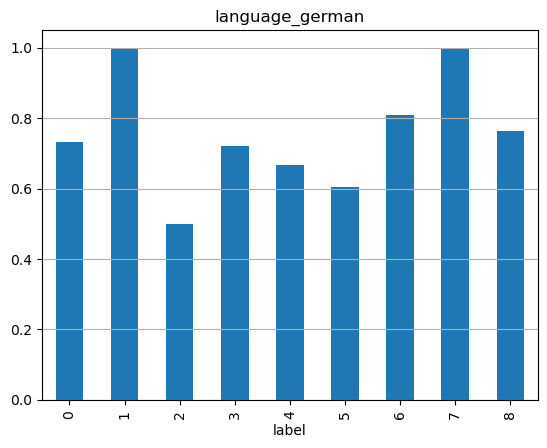

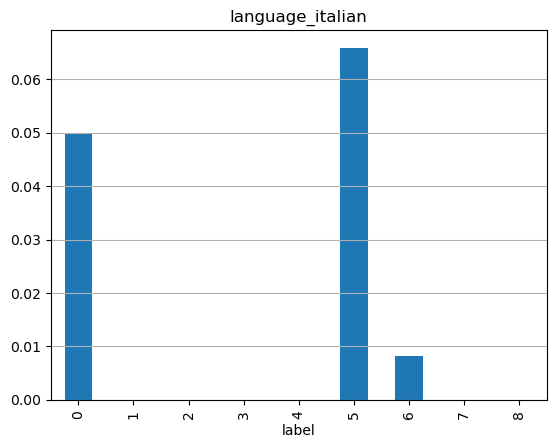

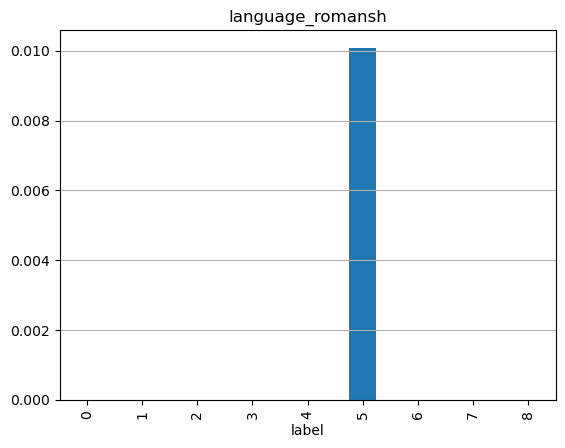

In [53]:
for col in group.columns:
    group[col].plot(kind="bar")
    plt.title(col)
    plt.grid(axis="y")
    plt.show()

In [54]:
group.describe()

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,98444.142819,18473.899052,5962.431396,17039.647061,63207.364226,15382.583859,45876.707992,5920.887414,101200.379571,111.203871,...,0.049921,0.214219,0.000672,0.035092,0.573424,0.172741,0.229479,0.755560,0.013766,0.001120
std,141906.859175,28086.807868,8010.448340,24021.992557,93148.750737,20576.450826,66888.327422,9257.507301,160246.919336,59.719893,...,0.073311,0.217115,0.002016,0.057571,0.199427,0.158949,0.159002,0.166018,0.025440,0.003360
min,929.380376,127.896505,139.445565,187.694220,542.192876,169.184812,380.578629,10.231834,337.774866,32.500000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.500000,0.000000,0.000000
25%,10344.173554,1485.429752,1075.173554,2003.123967,5983.950413,1917.636364,4330.950413,325.477342,5551.090909,83.777778,...,0.000000,0.000000,0.000000,0.000000,0.493213,0.116263,0.181818,0.666667,0.000000,0.000000
50%,27999.882353,4765.058824,2458.411765,5382.411765,16563.058824,5295.117647,12348.647059,1155.479636,17029.882353,92.809917,...,0.000000,0.176471,0.000000,0.000000,0.561983,0.126697,0.235294,0.733032,0.000000,0.000000
75%,133487.666667,27808.000000,7798.666667,24039.666667,84343.000000,20674.666667,61979.666667,5364.199973,128554.666667,166.666667,...,0.092593,0.316742,0.000000,0.058824,0.647059,0.203704,0.319892,0.809917,0.008264,0.000000
max,433989.000000,86847.000000,25386.000000,73514.000000,284691.000000,62012.000000,204411.000000,26041.886202,491193.000000,206.666667,...,0.206612,0.666667,0.006048,0.173387,1.000000,0.500000,0.500000,1.000000,0.065860,0.010081


In [55]:
group_percentage = group.copy()
for col in group.columns:
    group_percentage[col] = group[col]/group[col].sum()
group_percentage

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
label,,,,,,,,,,,,,,,,,,,,,
0,0.005207,0.003816,0.010117,0.006006,0.004722,0.006052,0.004637,0.001900,0.002181,0.087533,...,0.251781,0.164287,0.0,0.186252,0.095569,0.081494,0.105163,0.107798,0.401730,0.0
1,0.489831,0.522341,0.473073,0.479366,0.500453,0.447924,0.495073,0.488701,0.539296,0.176852,...,0.000000,0.000000,0.0,0.000000,0.193768,0.000000,0.000000,0.147058,0.000000,0.0
2,0.216120,0.178967,0.179205,0.214425,0.216364,0.235663,0.215534,0.316948,0.204244,0.032473,...,0.000000,0.000000,0.0,0.000000,0.096884,0.321612,0.242094,0.073529,0.000000,0.0
3,0.020208,0.015803,0.029750,0.022571,0.018692,0.023317,0.018414,0.014688,0.012271,0.083708,...,0.206087,0.086447,0.0,0.000000,0.118414,0.131027,0.134497,0.106209,0.000000,0.0
4,0.150664,0.167251,0.145330,0.156756,0.148265,0.149337,0.150112,0.100664,0.141144,0.206494,...,0.000000,0.000000,0.0,0.000000,0.129179,0.214408,0.161396,0.098039,0.000000,0.0
5,0.001049,0.000769,0.002599,0.001224,0.000953,0.001222,0.000922,0.000192,0.000371,0.046710,...,0.082269,0.183350,1.0,0.548993,0.067324,0.074783,0.154888,0.088749,0.531566,1.0
6,0.011675,0.008934,0.020036,0.013062,0.010519,0.013851,0.010489,0.006108,0.006095,0.092733,...,0.459864,0.128598,0.0,0.078503,0.108894,0.101002,0.088034,0.119105,0.066704,0.0
7,0.073643,0.073459,0.094077,0.071493,0.070916,0.084386,0.074911,0.049115,0.075701,0.166528,...,0.000000,0.345786,0.0,0.000000,0.064589,0.000000,0.000000,0.147058,0.000000,0.0
8,0.031603,0.028659,0.045813,0.035097,0.029116,0.038248,0.029908,0.021684,0.018698,0.106970,...,0.000000,0.091532,0.0,0.186252,0.125379,0.075673,0.113927,0.112456,0.000000,0.0


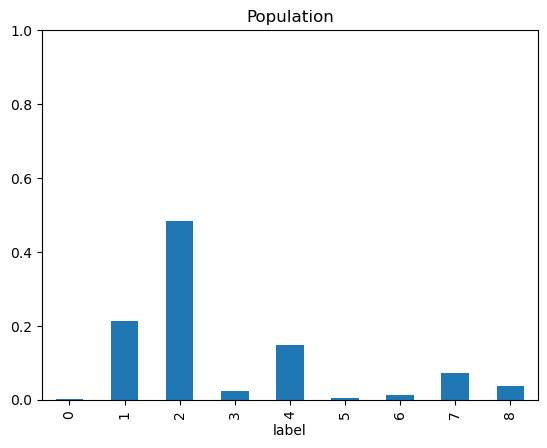

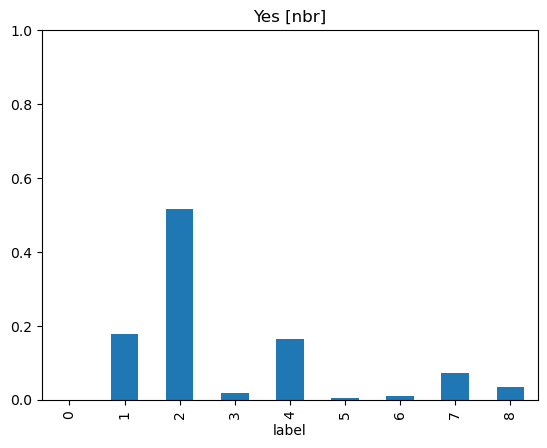

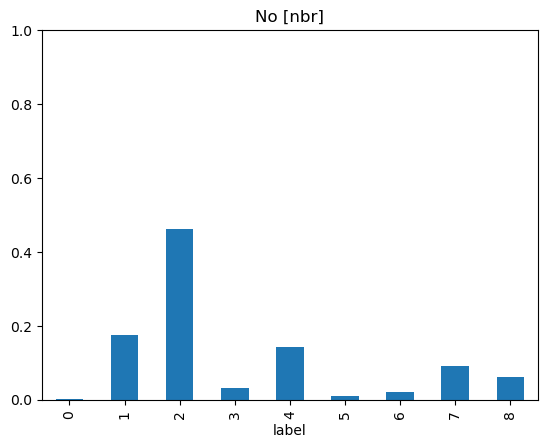

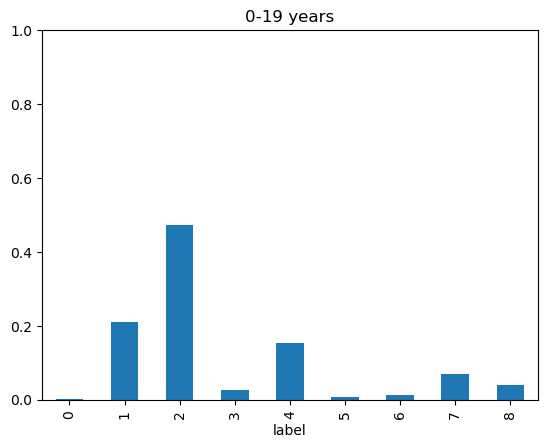

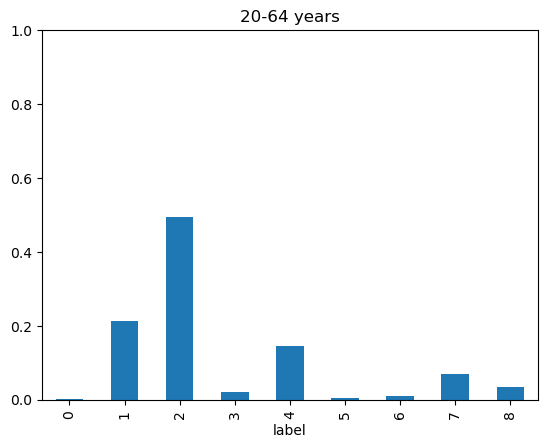

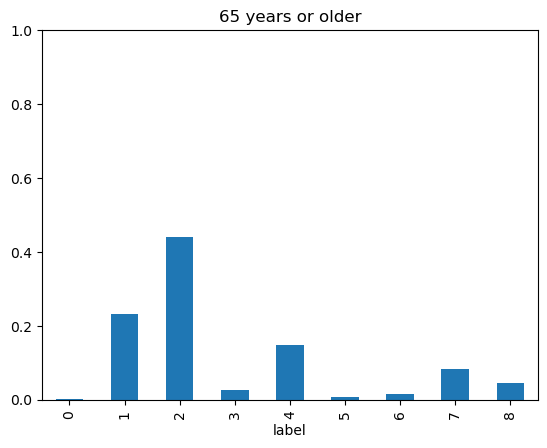

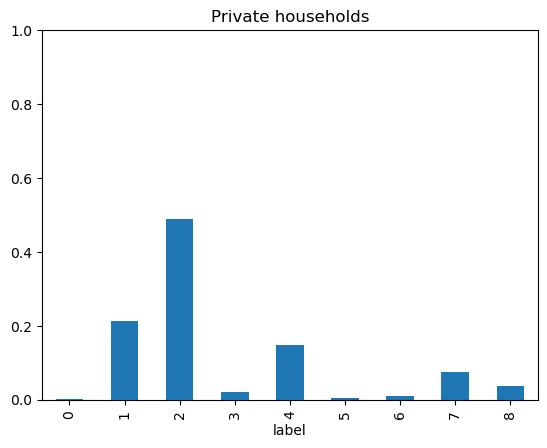

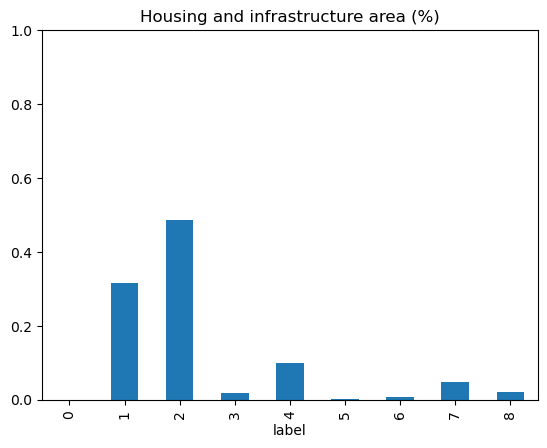

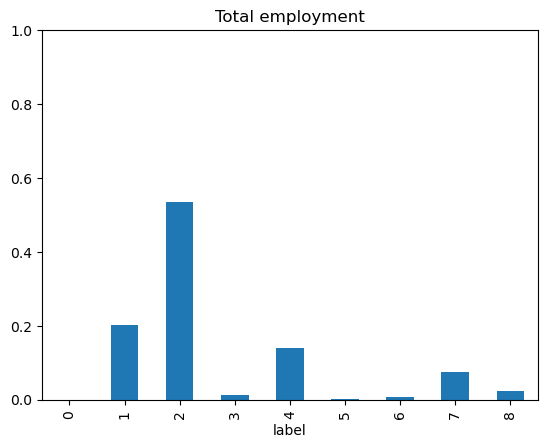

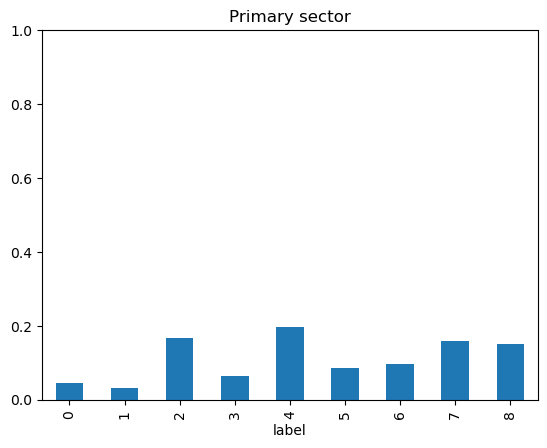

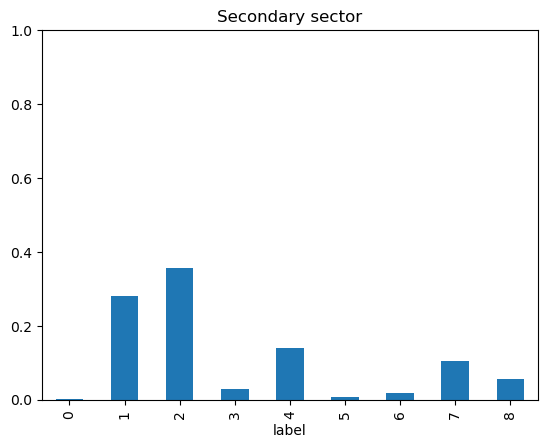

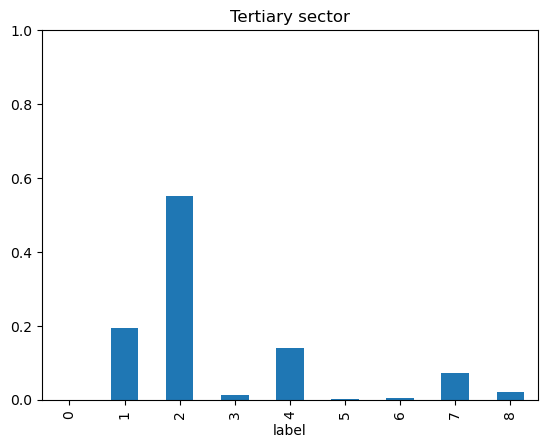

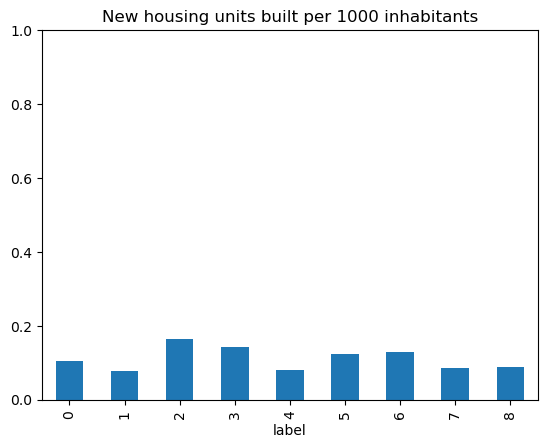

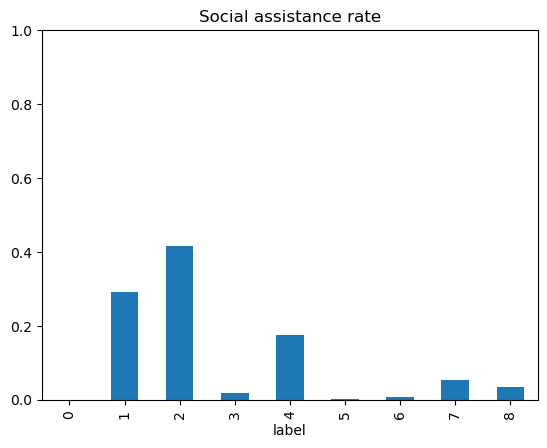

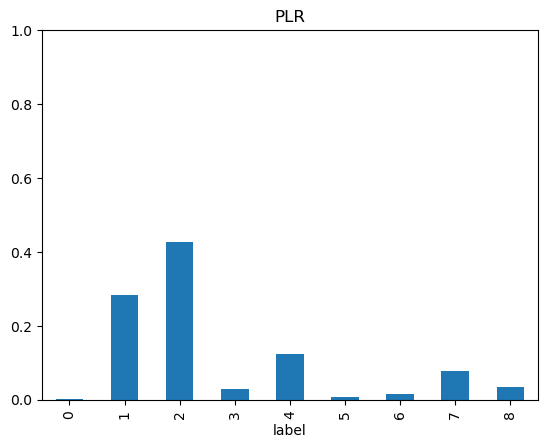

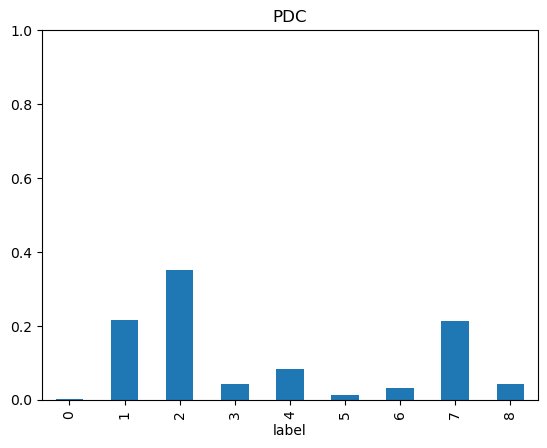

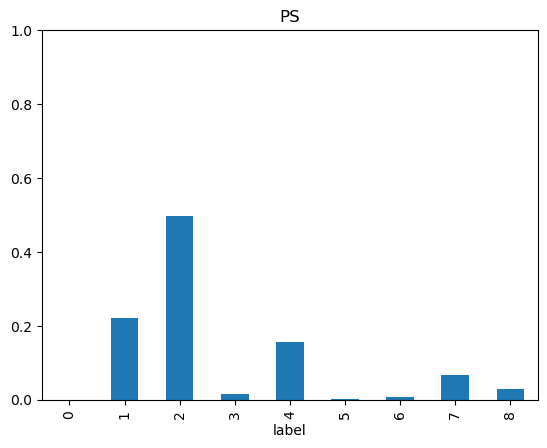

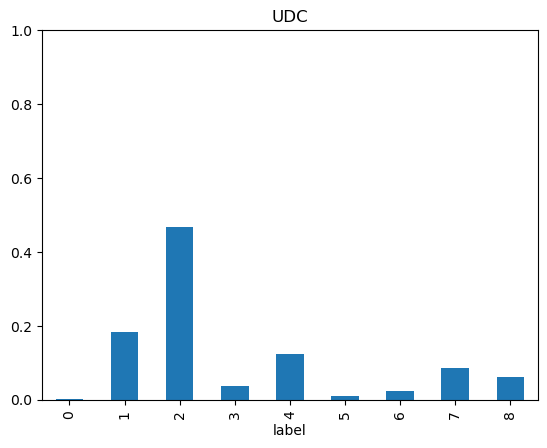

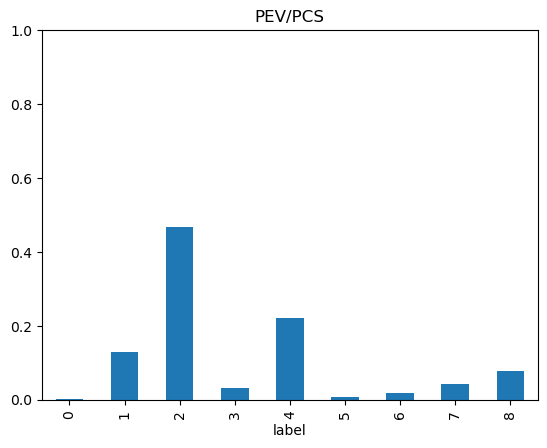

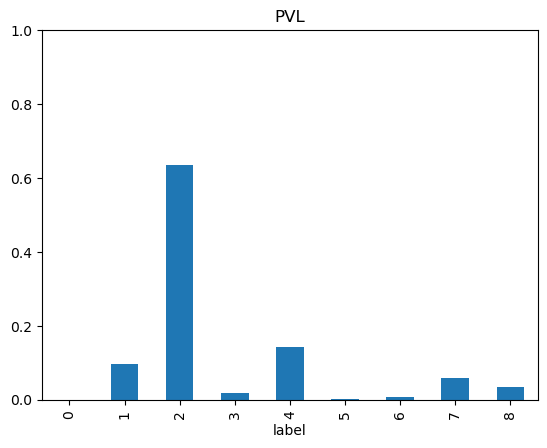

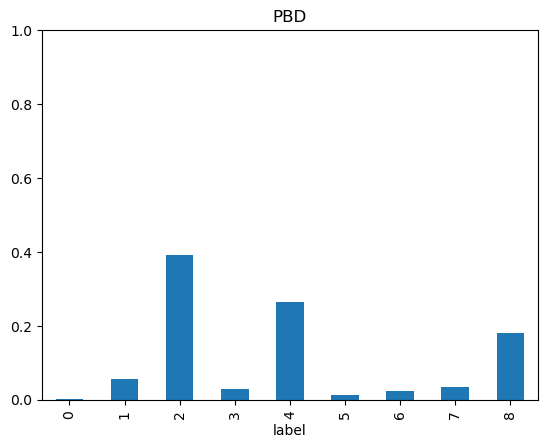

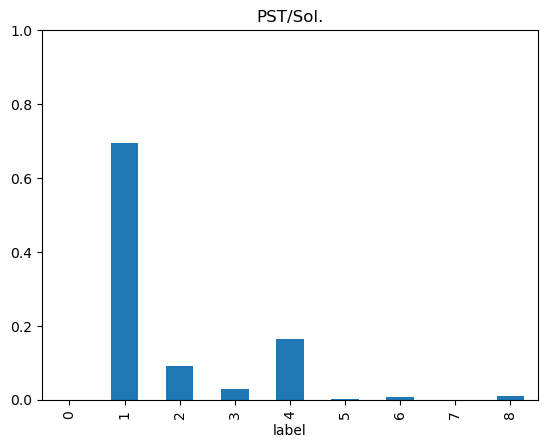

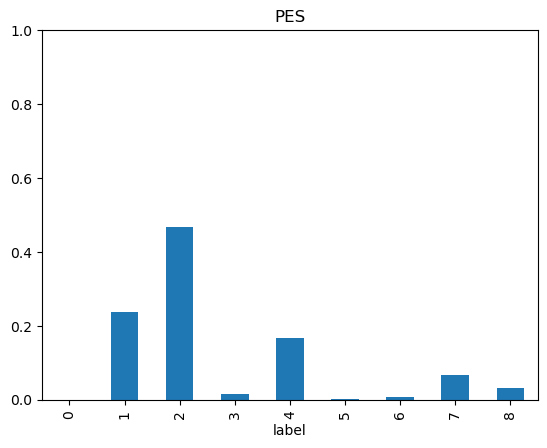

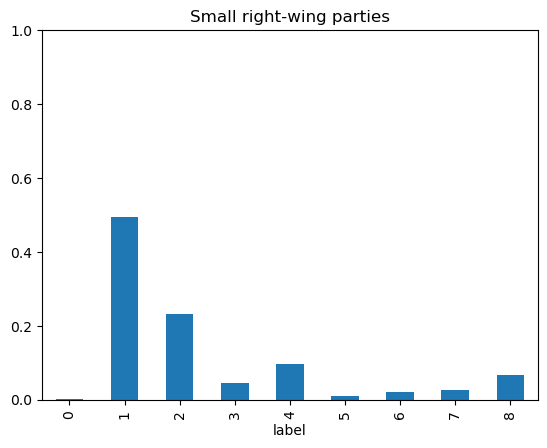

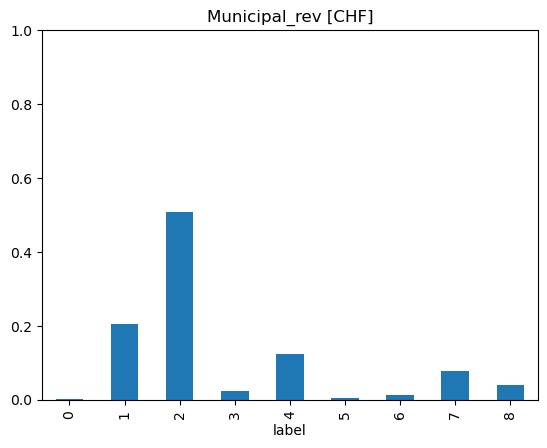

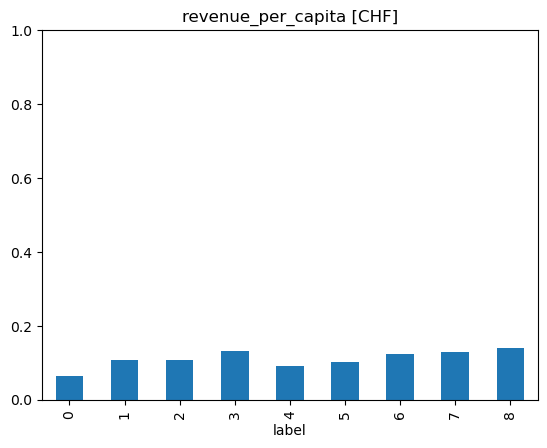

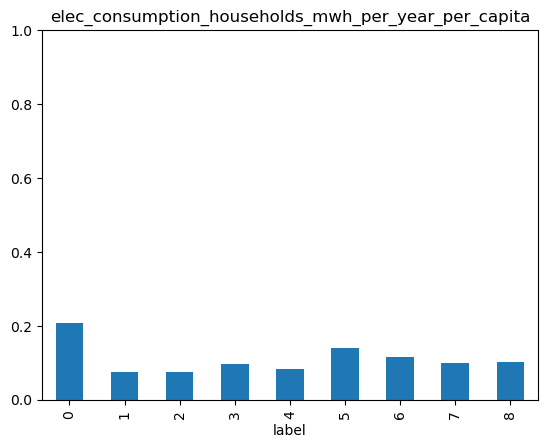

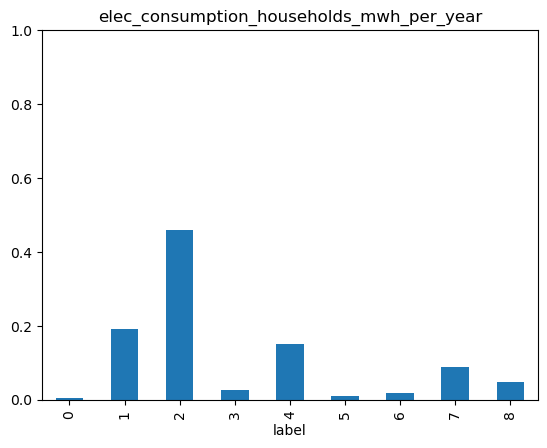

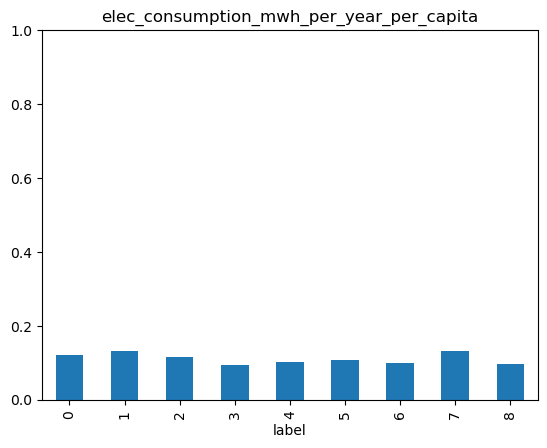

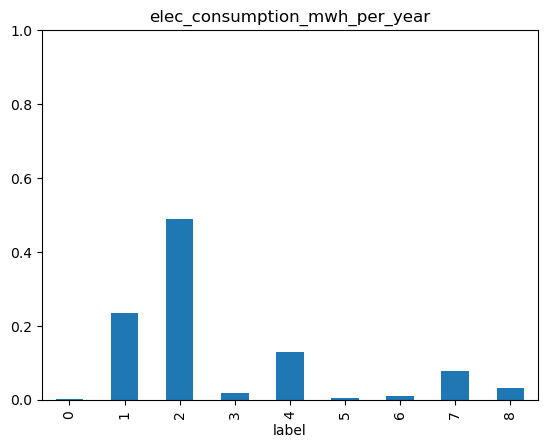

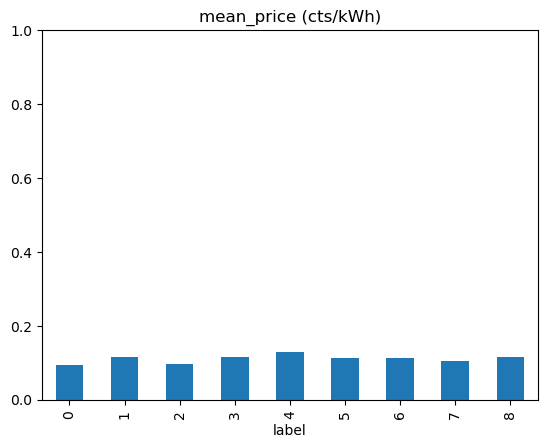

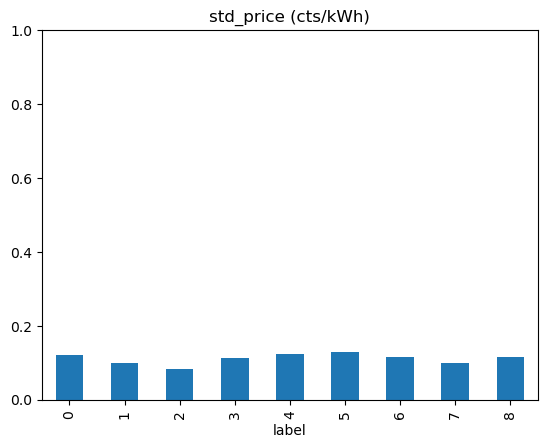

In [41]:
for index, row in group_percentage.iterrows():
    row.plot(kind="bar")
    plt.title(index)
    plt.ylim([0,1])
    plt.show()

C:\Users\godenzi\AppData\Local\Temp\ipykernel_15280\3374143607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(group_percentage))  # Choose 'tab10' or another colormap


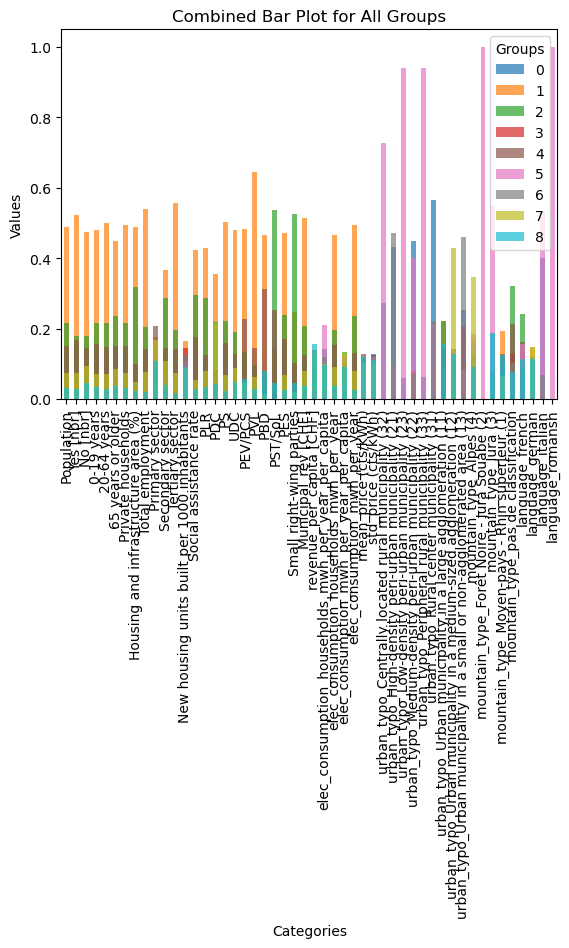

In [56]:
import matplotlib.cm as cm
# Generate a color map with distinct colors for each group
colors = cm.get_cmap('tab10', len(group_percentage))  # Choose 'tab10' or another colormap

# Plot all rows in a single bar plot
ax = None  # To keep track of the axes

# Loop through each row and assign a different color
for i, (index, row) in enumerate(group_percentage.iterrows()):
    ax = row.plot(
        kind="bar",
        ax=ax,
        color=colors(i),  # Assign a color from the colormap
        label=index,
        alpha=0.7
    )

# Add legend, title, and labels
plt.legend(title="Groups")
plt.title("Combined Bar Plot for All Groups")
plt.xlabel("Categories")
plt.ylabel("Values")
plt.show()



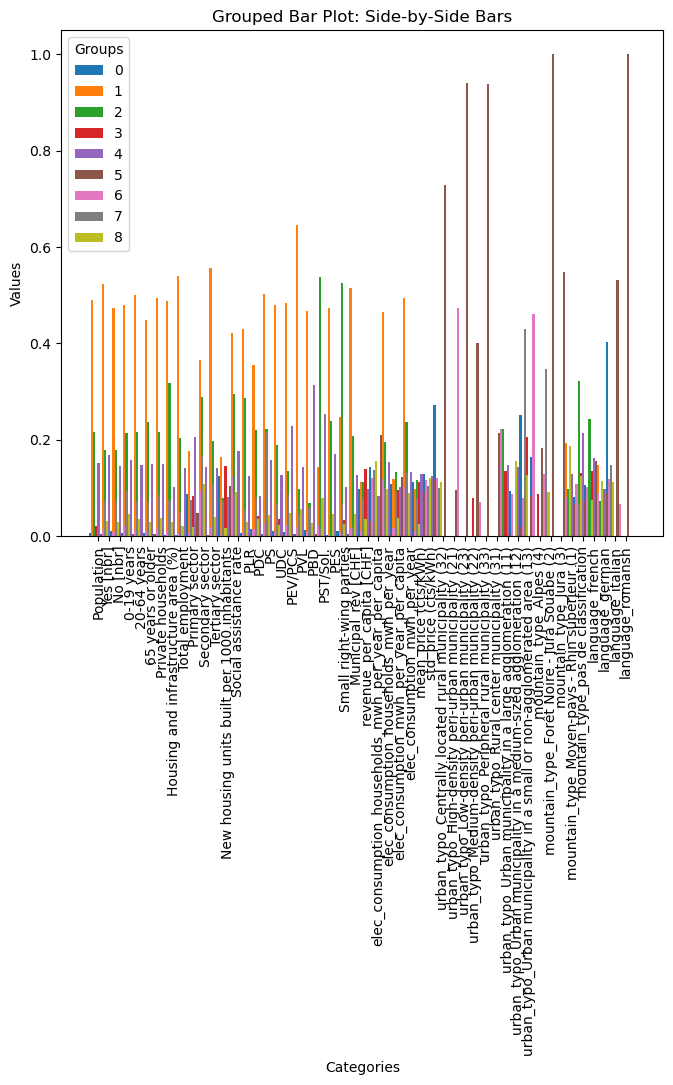

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame to have categories on the x-axis
group_percentage = group_percentage.T

# Bar width and x positions
categories = group_percentage.index
groups = group_percentage.columns
x = np.arange(len(categories))  # X positions for categories
width = 0.2  # Width of each bar

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(8, 6))

# Generate distinct colors for each group
colors = plt.cm.tab10.colors  # Colormap with distinct colors

for i, group in enumerate(groups):
    ax.bar(
        x + i * width,  # Shift bars for each group
        group_percentage[group],
        width,
        label=group,
        color=colors[i % len(colors)]  # Cycle through colors
    )

# Add labels, title, legend, and ticks
ax.set_xlabel("Categories")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Plot: Side-by-Side Bars")
ax.set_xticks(x + width * (len(groups) - 1) / 2)  # Center the group labels
ax.set_xticklabels(categories)
ax.legend(title="Groups")

# Show the plot
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
